# Dataset

In this notebook we will download the dataset from kaggle, we'll explore it and we will select a reduced number of artists in order to remove the artists that have too less paintings. Then we will create the training set and the test set splitting the images in the folder using a 0.8 0.2 splitting ratio. We want to keep the tree of directories as it is since it's in the form required to be read by the *image_dataset_from_directory* method. We will save the dataset in a shared folder on Google Drive.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

! pip install split-folders
! pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Donwload of the dataset
The first thing that we do is the download of the dataset from kaggle

In [ ]:
#Upload kaggle.json with the username and the key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabianopilia","key":"54df62178d599d0288e40d24e50aabf2"}'}

In [ ]:
#Creation of the dir for kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#The following is the command to show the datasets avaialble to be downloaded

! kaggle datasets list

ref                                                           title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                             9MB  2023-03-20 15:43:25           1824         73  1.0              
dgoenrique/netflix-movies-and-tv-shows                        Netflix Movies and TV Shows                     2MB  2023-03-13 18:49:00           1255         37  1.0              
rajkumarpandey02/list-of-countries-by-gdp-sector-composition  List of Countries by GDP Sector Composition     8KB  2023-03-20 04:42:10           1235         44  1.0              
datascientistanna/customers-dataset                           Shop Customer Data                    

Now we download the *best-artworks-of-all-time* dataset

In [ ]:
#Command to download the dataset
! kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [01:08<00:00, 40.1MB/s]
100% 2.29G/2.29G [01:08<00:00, 35.9MB/s]


In [ ]:
#Unzip the dataset (use unzip -qq to download it silently)
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

# Correct names of the classes

In [ ]:
#read the csv file artists, that file contains the metadata for each artist
artists = pd.read_csv("artists.csv")

In [ ]:
#Print the first 50 rows of the dataframe
artists.head(50)

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


In [ ]:
#Print the shape of the dataset: We have 50 rows and 8 columns
artists.shape

(50, 8)

In [ ]:
#Print the content of images/images/ folder, for each artist we have one folder
# containing its images; we can consider each folder as a class and the images
# inside the folder are samples belonging to the class.
os.listdir("images/images/")

['Camille_Pissarro',
 'Frida_Kahlo',
 'Rene_Magritte',
 'Paul_Klee',
 'Henri_Matisse',
 'Andrei_Rublev',
 'Edgar_Degas',
 'Pierre-Auguste_Renoir',
 'Caravaggio',
 'Jackson_Pollock',
 'Salvador_Dali',
 'Peter_Paul_Rubens',
 'Piet_Mondrian',
 'Pablo_Picasso',
 'Mikhail_Vrubel',
 'Andy_Warhol',
 'Paul_Cezanne',
 'Gustave_Courbet',
 'Edouard_Manet',
 'Vincent_van_Gogh',
 'Henri_de_Toulouse-Lautrec',
 'William_Turner',
 'Albrecht_Du╠Иrer',
 'Jan_van_Eyck',
 'Raphael',
 'Edvard_Munch',
 'Amedeo_Modigliani',
 'El_Greco',
 'Leonardo_da_Vinci',
 'Titian',
 'Alfred_Sisley',
 'Marc_Chagall',
 'Paul_Gauguin',
 'Claude_Monet',
 'Henri_Rousseau',
 'Diego_Rivera',
 'Eugene_Delacroix',
 'Joan_Miro',
 'Diego_Velazquez',
 'Hieronymus_Bosch',
 'Sandro_Botticelli',
 'Pieter_Bruegel',
 'Gustav_Klimt',
 'Michelangelo',
 'Vasiliy_Kandinskiy',
 'Albrecht_DuтХа├кrer',
 'Kazimir_Malevich',
 'Giotto_di_Bondone',
 'Georges_Seurat',
 'Francisco_Goya',
 'Rembrandt']

As we can see in the output of the previous cell we have two folders for the same artist, we've inspected the folders and they have the same content, so
we can drop one of them; we've decided to drop the following one:

In [ ]:
shutil.rmtree('images/images/Albrecht_DuтХа├кrer')

Check if the folder was dropped checking the size of the list of directories:

In [ ]:
len(os.listdir("images/images/"))

50

Now we want to have the names of the folders equal to the names of the artists in the artist.csv file, basically we have to replace "_" with " ":

In [ ]:
for image_dir in os.listdir("images/images/"):
  image_dir_new = image_dir
  image_dir_new = image_dir_new.replace("_", " ")
  os.rename("images/images/"+image_dir,"images/images/"+image_dir_new)

# Print the new names
os.listdir("images/images/")

['Diego Rivera',
 'Rene Magritte',
 'Joan Miro',
 'Camille Pissarro',
 'Georges Seurat',
 'Peter Paul Rubens',
 'William Turner',
 'Caravaggio',
 'Edgar Degas',
 'Salvador Dali',
 'Frida Kahlo',
 'Mikhail Vrubel',
 'Kazimir Malevich',
 'Gustave Courbet',
 'Jan van Eyck',
 'Andrei Rublev',
 'Pierre-Auguste Renoir',
 'Piet Mondrian',
 'Jackson Pollock',
 'Henri Rousseau',
 'Giotto di Bondone',
 'Andy Warhol',
 'Pieter Bruegel',
 'Henri de Toulouse-Lautrec',
 'Raphael',
 'Paul Cezanne',
 'Henri Matisse',
 'Paul Klee',
 'Titian',
 'Diego Velazquez',
 'Francisco Goya',
 'Albrecht Du╠Иrer',
 'Sandro Botticelli',
 'Leonardo da Vinci',
 'Alfred Sisley',
 'Edvard Munch',
 'Edouard Manet',
 'Vincent van Gogh',
 'Marc Chagall',
 'Amedeo Modigliani',
 'El Greco',
 'Eugene Delacroix',
 'Michelangelo',
 'Hieronymus Bosch',
 'Pablo Picasso',
 'Vasiliy Kandinskiy',
 'Claude Monet',
 'Paul Gauguin',
 'Gustav Klimt',
 'Rembrandt']

We have to change the name from "Albrecht Du╠Иrer" to the name in artists.csv "Albrecht Dürer":

In [ ]:
os.rename("images/images/Albrecht Du╠Иrer","images/images/Albrecht Dürer")
os.listdir("images/images/")

['Diego Rivera',
 'Rene Magritte',
 'Joan Miro',
 'Camille Pissarro',
 'Georges Seurat',
 'Peter Paul Rubens',
 'William Turner',
 'Caravaggio',
 'Edgar Degas',
 'Salvador Dali',
 'Frida Kahlo',
 'Mikhail Vrubel',
 'Kazimir Malevich',
 'Gustave Courbet',
 'Jan van Eyck',
 'Andrei Rublev',
 'Pierre-Auguste Renoir',
 'Piet Mondrian',
 'Jackson Pollock',
 'Henri Rousseau',
 'Giotto di Bondone',
 'Andy Warhol',
 'Pieter Bruegel',
 'Henri de Toulouse-Lautrec',
 'Raphael',
 'Paul Cezanne',
 'Albrecht Dürer',
 'Henri Matisse',
 'Paul Klee',
 'Titian',
 'Diego Velazquez',
 'Francisco Goya',
 'Sandro Botticelli',
 'Leonardo da Vinci',
 'Alfred Sisley',
 'Edvard Munch',
 'Edouard Manet',
 'Vincent van Gogh',
 'Marc Chagall',
 'Amedeo Modigliani',
 'El Greco',
 'Eugene Delacroix',
 'Michelangelo',
 'Hieronymus Bosch',
 'Pablo Picasso',
 'Vasiliy Kandinskiy',
 'Claude Monet',
 'Paul Gauguin',
 'Gustav Klimt',
 'Rembrandt']

# Building training and testing set

Abbiamo deciso di ridurre il numero delle immagini perchè da test precedenti il tempo di training è risultato insostenibile. (indefinito)
Siamo andati a tentativi e abbiamo deciso di utilizzare gli artisti con più di 150 dipinti, se il tempo sarà ancora troppo incrementiamo di 50.

In [ ]:
print(("Total number of paintings of artist with more than 100 paintings: {paintings_100}").format(paintings_100 = sum(artists[artists["paintings"] > 100]["paintings"])))
print(("Total number of paintings in the whole dataset: {paintings_tot}").format(paintings_tot = sum(artists["paintings"])))
print(("Number of classes considering artist with more than 100 paintings: {classes_100}").format(classes_100 = artists[artists["paintings"] > 100].shape[0]))
print(("Number of classes considering the whole dataset: {classes_tot}").format(classes_tot = artists.shape[0]))

Total number of paintings of artist with more than 100 paintings: 7091
Total number of paintings in the whole dataset: 8446
Number of classes considering artist with more than 100 paintings: 30
Number of classes considering the whole dataset: 50


In [ ]:
print(("Total number of paintings of artist with more than 150 paintings: {paintings_150}").format(paintings_150 = sum(artists[artists["paintings"] > 150]["paintings"])))
print(("Total number of paintings in the whole dataset: {paintings_tot}").format(paintings_tot = sum(artists["paintings"])))
print(("Number of classes considering artist with more than 150 paintings: {classes_150}").format(classes_150 = artists[artists["paintings"] > 150].shape[0]))
print(("Number of classes considering the whole dataset: {classes_tot}").format(classes_tot = artists.shape[0]))

Total number of paintings of artist with more than 150 paintings: 5576
Total number of paintings in the whole dataset: 8446
Number of classes considering artist with more than 150 paintings: 18
Number of classes considering the whole dataset: 50


Creation of a list of artists having more than 150 paintings, then we use this list in order to remove create the starting dataset

In [ ]:
# Create a list of artists with more than 150 paintings
list_of_artists = list(artists[artists["paintings"] > 150]["name"])
list_of_artists

['Amedeo Modigliani',
 'Rene Magritte',
 'Vincent van Gogh',
 'Mikhail Vrubel',
 'Pablo Picasso',
 'Pierre-Auguste Renoir',
 'Francisco Goya',
 'Albrecht Dürer',
 'Alfred Sisley',
 'Marc Chagall',
 'Sandro Botticelli',
 'Henri Matisse',
 'Edgar Degas',
 'Rembrandt',
 'Titian',
 'Paul Klee',
 'Andy Warhol',
 'Paul Gauguin']

We create a new dataframe with only the artists with more than 150 paintings and select only the attributes we need

In [ ]:
artists150 = artists[artists["paintings"] > 150]
artists150 = artists150[["name","genre","paintings"]].reset_index()
artists150.drop(["index"], inplace=True, axis=1)
artists150

,name,genre,paintings
0,Amedeo Modigliani,Expressionism,193
1,Rene Magritte,"Surrealism,Impressionism",194
2,Vincent van Gogh,Post-Impressionism,877
3,Mikhail Vrubel,Symbolism,171
4,Pablo Picasso,Cubism,439
5,Pierre-Auguste Renoir,Impressionism,336
6,Francisco Goya,Romanticism,291
7,Albrecht Dürer,Northern Renaissance,328
8,Alfred Sisley,Impressionism,259
9,Marc Chagall,Primitivism,239


In [ ]:
#Creation of a directory containing the directories of the artists with more
# than 150 paintings

for image_dir in os.listdir("images/images/"):
  if image_dir in list_of_artists:
    shutil.copytree("images/images/"+image_dir, "images/images150/"+image_dir)

In [ ]:
import splitfolders

# Split the folders in two folders with the same structure, one contains 80% of
# the images and the the other the 20%, the first will be the training set
# while the secondo will be the test set
splitfolders.ratio("images/images150", output="images/output150",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 5576 files [00:04, 1274.99 files/s]


In [ ]:
#rename the folder containing 0.2 of the dataset into test
os.rename("images/output150/val","images/output150/test")

In [ ]:
#Now we check if there is intersection between images in the test set and in the
# ones of the training set, since we don't want to test using images already
# used in the training phase

#We build two sets
set1 = set(os.listdir("images/output150/test/Vincent van Gogh"))
set2 = set(os.listdir("images/output150/train/Vincent van Gogh"))

#Print the len
print(len(set1))
print(len(set2))

#Make the intersection, we expect to obtain set()
set1.intersection(set2)

176
701


set()

# Save new artists150.csv in drive

In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we've our training set and test set and we want to save it inside the drive:

In [ ]:
# Create the dataset directory
dir_name = "/content/drive/Shareddrives/[Deep Learning Project]/Dataset"

if not os.path.exists(dir_name):
  os.makedirs(dir_name)

# Copy recursively the test set and the training set inside the dataset directory
for dir in os.listdir("images/output150"):
  shutil.copytree("images/output150/" + dir, dir_name+"/"+dir)

In [ ]:
#Save the artists info into a csv on the shared drive

artists150.to_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists150.csv', index=False)

In [ ]:
#Test of loading the csv file saved in the previous cell
artists150 = pd.read_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists150.csv')

In [ ]:
#Print the csv file as a dataframe
artists150

,name,genre,paintings
0,Amedeo Modigliani,Expressionism,193
1,Rene Magritte,"Surrealism,Impressionism",194
2,Vincent van Gogh,Post-Impressionism,877
3,Mikhail Vrubel,Symbolism,171
4,Pablo Picasso,Cubism,439
5,Pierre-Auguste Renoir,Impressionism,336
6,Francisco Goya,Romanticism,291
7,Albrecht Dürer,Northern Renaissance,328
8,Alfred Sisley,Impressionism,259
9,Marc Chagall,Primitivism,239


# Dataset distribution

<BarContainer object of 18 artists>

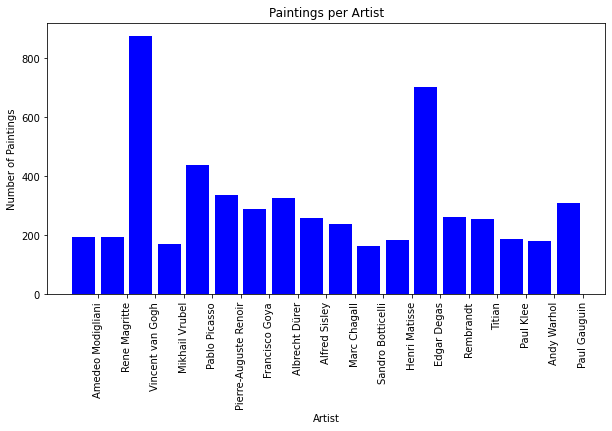

In [ ]:
#Now we want to see how the classes are balanced

plt.figure(figsize=(10,5))

artists_list= artists150["name"]
paintings_list = artists150["paintings"]

length = len(artists_list)

plt.xticks(np.arange(length) + .5, artists_list, rotation=90)
plt.xlabel("Artist")
plt.ylabel('Number of Paintings')
plt.title('Paintings per Artist')

plt.bar(artists_list, paintings_list, color='blue', label='Number of Painting by Artist')

# Assign weights to classes

Since the classes are imbalanced we want to use weights, we want to assign higher weight to the classes with less data in order to be learned more by the network

The first thing that we've tried is to use the method compute_class_weight of the sklearn library:

In [ ]:
print(artists150["paintings"])
print(sum(artists150["paintings"]))

dictionary = dict(zip(list(artists150["name"]), list(artists150["paintings"])))
class_occ = artists150["paintings"].to_numpy()

print(artists150["name"].to_numpy())
print(type(artists150["paintings"].to_numpy()))

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                     classes = artists150["name"].to_numpy(),
                                     y = artists150["name"].to_numpy())

0     193
1     194
2     877
3     171
4     439
5     336
6     291
7     328
8     259
9     239
10    164
11    186
12    702
13    262
14    255
15    188
16    181
17    311
Name: paintings, dtype: int64
5576
['Amedeo Modigliani' 'Rene Magritte' 'Vincent van Gogh' 'Mikhail Vrubel'
 'Pablo Picasso' 'Pierre-Auguste Renoir' 'Francisco Goya' 'Albrecht Dürer'
 'Alfred Sisley' 'Marc Chagall' 'Sandro Botticelli' 'Henri Matisse'
 'Edgar Degas' 'Rembrandt' 'Titian' 'Paul Klee' 'Andy Warhol'
 'Paul Gauguin']
<class 'numpy.ndarray'>


The problem using this function is the fact that we don't have the dataset composed by a list of sample composed by (image, class) that is the format required by the y parameter of this method. In fact we have a tree of directories in which each one is a class, so this function don't cope with our dataset's structure -> we need to find another way

In [ ]:
artists150

,name,genre,paintings
0,Amedeo Modigliani,Expressionism,193
1,Rene Magritte,"Surrealism,Impressionism",194
2,Vincent van Gogh,Post-Impressionism,877
3,Mikhail Vrubel,Symbolism,171
4,Pablo Picasso,Cubism,439
5,Pierre-Auguste Renoir,Impressionism,336
6,Francisco Goya,Romanticism,291
7,Albrecht Dürer,Northern Renaissance,328
8,Alfred Sisley,Impressionism,259
9,Marc Chagall,Primitivism,239


The second solution that we've found is to implement the same weighting implemented by the previous compute_class_weight method.

The weight is equal to:
$\frac{tot}{(tot\_classes) \cdot (occurrence\_class\_i)}$

* tot = total number of samples
* tot_classes = total number of classes
* occurrence_class_i = number of samples belonging to a class

In [ ]:
class_weights = []

class_occ = artists150["paintings"].to_numpy() #array of occurrences
number_of_samples = sum(class_occ) #tot
number_of_classes = len(class_occ) #tot_Classes


print("number of samples: ",number_of_samples)
print("number of classes: ",number_of_classes)

#for each total number of occurrencese for each class we compute the weights
for occ in class_occ:
  weight = number_of_samples / (number_of_classes*occ)
  class_weights.append(weight)

dict(zip(list(artists150["name"]), class_weights))

artists150 = artists150.assign(weight=class_weights)

artists150.sort_values("weight")
#As we can see in the results we have a low weight for the artists with a lot of
# paintings, while bigger weight for artists with fewer paintings

number of samples:  5576
number of classes:  18


,name,genre,paintings,weight
2,Vincent van Gogh,Post-Impressionism,877,0.353224
12,Edgar Degas,Impressionism,702,0.441279
4,Pablo Picasso,Cubism,439,0.705644
5,Pierre-Auguste Renoir,Impressionism,336,0.921958
7,Albrecht Dürer,Northern Renaissance,328,0.944444
17,Paul Gauguin,"Symbolism,Post-Impressionism",311,0.996070
6,Francisco Goya,Romanticism,291,1.064528
13,Rembrandt,Baroque,262,1.182358
8,Alfred Sisley,Impressionism,259,1.196053
14,Titian,"High Renaissance,Mannerism",255,1.214815


In [ ]:
#Save the artists info into a csv on the shared drive
artists150.to_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists150.csv', index=False)

In [ ]:
def take_classes_size(directory):
  classes_size=[]
  classes_name=[]
  for dir in os.listdir(directory):
    dir_size=len(os.listdir(directory+"/"+dir))
    classes_size.append(dir_size)
    classes_name.append(dir)
    print(dir+": ",dir_size)
  return classes_name,classes_size

In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
#Check if the dataset is correctly loaded
classes_name, classes_size = take_classes_size(train_dir)
print("\nTotal training paintings:", sum(classes_size))

Rene Magritte:  155
Edgar Degas:  561
Mikhail Vrubel:  136
Pierre-Auguste Renoir:  268
Andy Warhol:  144
Albrecht Dürer:  262
Henri Matisse:  148
Paul Klee:  150
Titian:  204
Francisco Goya:  232
Sandro Botticelli:  131
Alfred Sisley:  207
Vincent van Gogh:  701
Marc Chagall:  191
Amedeo Modigliani:  154
Pablo Picasso:  351
Paul Gauguin:  248
Rembrandt:  209

Total training paintings: 4452


In [ ]:
#Check if the dataset is correctly loaded
classes_name, classes_size = take_classes_size(test_dir)
print("\nTotal test paintings:", sum(classes_size))

Rene Magritte:  39
Edgar Degas:  129
Mikhail Vrubel:  35
Pierre-Auguste Renoir:  68
Andy Warhol:  37
Albrecht Dürer:  66
Henri Matisse:  38
Paul Klee:  38
Titian:  51
Francisco Goya:  59
Sandro Botticelli:  33
Alfred Sisley:  52
Vincent van Gogh:  176
Marc Chagall:  48
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  63
Rembrandt:  53

Total test paintings: 1112
